In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import copy
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [55]:
# 建模流程: https://zhuanlan.zhihu.com/p/432193136
## 数据获取
## 数据预处理: 数据清洗/异常值/缺失值/类型转换
## EDA: 数据分析/描述性统计
## 变量选择: iv/feature important/方差
## 模型开发: woe分箱(50多种)/分数拉伸/变量系数计算
## 模型验证: 模型区分能力/预测能力/稳定性/排序能力
## 信用评分卡
## 模型监控

# 1. 数据读取及变量解释

In [2]:
# https://cloud.tencent.com/developer/article/1448182
# x0:SeriousDlqin2yrs：好坏客户(1: 坏客户; 0: 好客户)
# x1:RevolvingUtilization Of UnsecuredLines：无担保放款的循环利用：除了不动产和像车贷那样除以信用额度总和的无分期付款债务的信用卡和个人信用额度总额/可用额度比值
# x2:Age：借款人年龄
# x3:NumberOfTime30-59DaysPastDueNotWorse：30-59天逾期次数
# x4:DebtRatio：负债比例
# x5:MonthlyIncome：月收入
# x6:Number Of OpenCreditLinesAndLoans：开放式信贷和贷款数量
# x7:NumberOfTimes90DaysLate：90天逾期次数：借款者有90天或更高逾期的次数
# x8:NumberReal Estate Loans Or Lines：不动产贷款或额度数量：抵押贷款和不动产放款包括房屋净值信贷额度
# x9:Number Of Time 60-89Days PastDue Not Worse：60-89天逾期次数
# x10:NumberOfDependents：家属数量,不包括本人在内的家属数量

In [3]:
# home_path
home_path = os.path.abspath(".")

In [4]:
train_data_file = os.path.join(home_path, 'data/cs-training.csv')
test_data_file = os.path.join(home_path, 'data/cs-test.csv')
train_data = pd.read_csv(train_data_file)
test_data = pd.read_csv(test_data_file)

print("train_data shape: ", train_data.shape)
print("train_data info: ", train_data.info())
print("======================================================")
print("test_data shape: ", test_data.shape)
print("test_data info: ", test_data.info())

train_data shape:  (150000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse

# 2.数据分析和探索

## 查看各数据特征分布

In [5]:
train_data.set_index('Unnamed: 0', inplace=True)
test_data.set_index('Unnamed: 0', inplace=True)

In [6]:
train_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
Unnamed: 0,,,,,,,,,,,
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


### 2.1 查看好坏客户分布

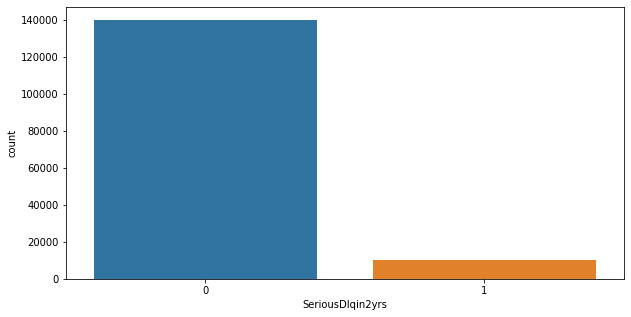

训练集数据中，好客户数量为：139974,坏客户数量为：10026,坏客户所占比例为：6.68%
样本标签及其不平衡，后面需要使用balance参数


In [7]:

fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot('SeriousDlqin2yrs', data = train_data)
plt.show()
bad_num = train_data['SeriousDlqin2yrs'].sum()
good_num = train_data['SeriousDlqin2yrs'].count() - bad_num
print('训练集数据中，好客户数量为：%i,坏客户数量为：%i,坏客户所占比例为：%.2f%%' %(good_num, bad_num, (bad_num/train_data['SeriousDlqin2yrs'].count())*100))
print("样本标签及其不平衡，后面需要使用balance参数")

### 2.2 可用额度比值特征分布

In [8]:
# f, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
# sns.displot(train_data['RevolvingUtilizationOfUnsecuredLines'], ax=ax1)
# sns.boxplot(y='RevolvingUtilizationOfUnsecuredLines', data=train_data, ax=ax2)
# plt.show()
print("RevolvingUtilizationOfUnsecuredLines describe: ", train_data['RevolvingUtilizationOfUnsecuredLines'].describe())

RevolvingUtilizationOfUnsecuredLines describe:  count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64


### 2.3 年龄分布

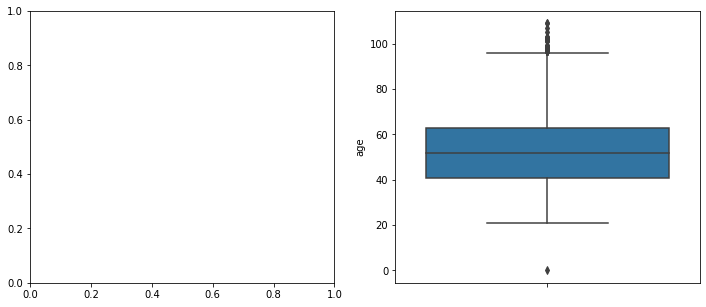

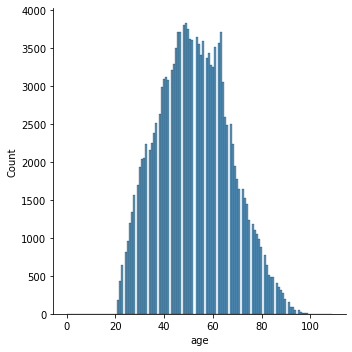

age < 18:  1
age > 100:  13


In [9]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
sns.displot(train_data['age'], ax=ax1)
sns.boxplot(y='age', data=train_data, ax=ax2)
plt.show()

print("age < 18: ", train_data[train_data['age']<18].shape[0])        # 只有1条，而且年龄为0，后面当做异常值删除
print("age > 100: ", train_data[train_data['age']>100].shape[0])      # 较多且连续，可暂时保留

### 2.4 逾期30-59天 | 60-89天 | 90天笔数分布

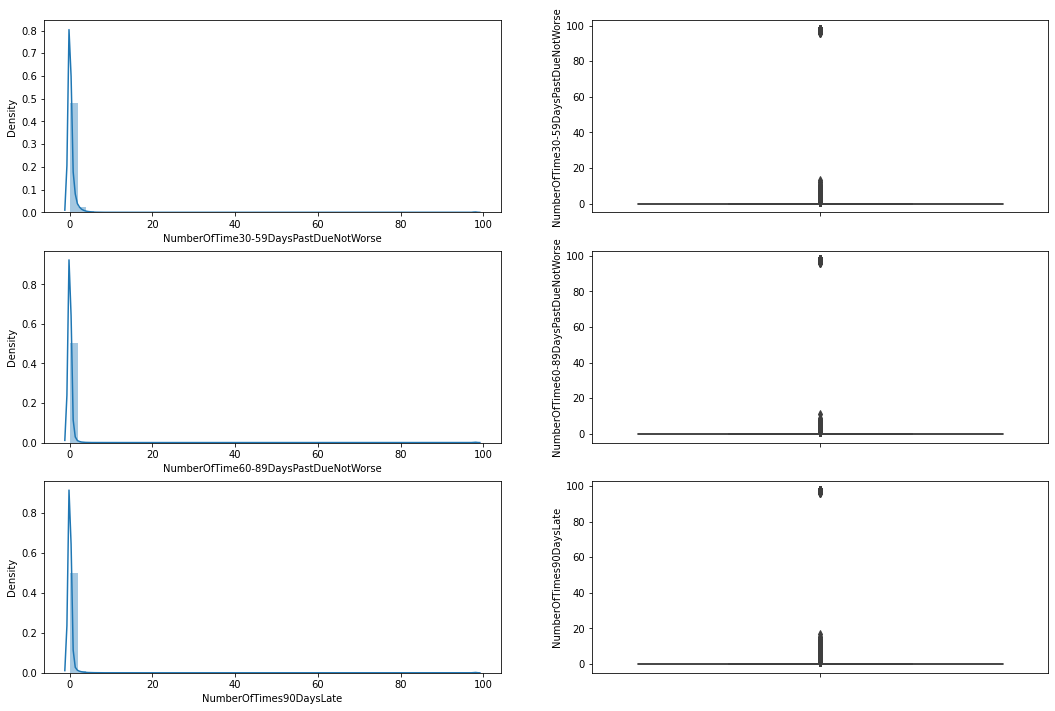

269
----------------------
269
----------------------
269
----------------------


In [10]:
f,[[ax1,ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2,figsize=(18,12))
sns.distplot(train_data['NumberOfTime30-59DaysPastDueNotWorse'],ax=ax1)
sns.boxplot(y='NumberOfTime30-59DaysPastDueNotWorse',data=train_data,ax=ax2)
sns.distplot(train_data['NumberOfTime60-89DaysPastDueNotWorse'],ax=ax3)
sns.boxplot(y='NumberOfTime60-89DaysPastDueNotWorse',data=train_data,ax=ax4)
sns.distplot(train_data['NumberOfTimes90DaysLate'],ax=ax5)
sns.boxplot(y='NumberOfTimes90DaysLate',data=train_data,ax=ax6)
plt.show()

print(train_data[train_data['NumberOfTime30-59DaysPastDueNotWorse']>13].shape[0])
print('----------------------')
# 这里可以看出逾期30-59天次数大于13次的有269条，大于80次的也是269条，说明这些是异常值，应该删除
print(train_data[train_data['NumberOfTime60-89DaysPastDueNotWorse']>13].shape[0])
print('----------------------')
# 这里可以看出逾期60-89天次数大于13次的有269条，大于80次的也是269条，说明这些是异常值，应该删除
print(train_data[train_data['NumberOfTimes90DaysLate']>17].shape[0])
print('----------------------')
# 这里可以看出逾期90天以上次数大于17次的有269条，大于80次的也是269条，说明这些是异常值，应该删除

### 2.5负债率特征分布

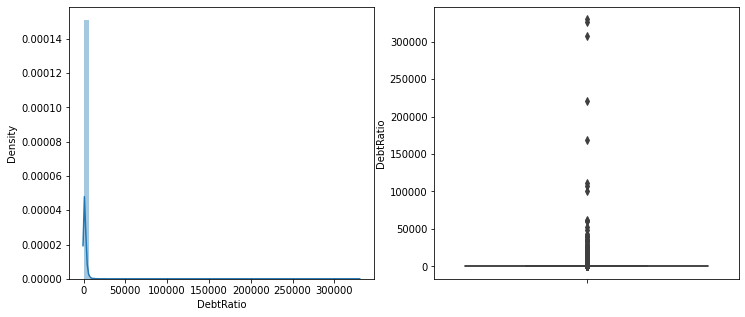

count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max      329664.000000
Name: DebtRatio, dtype: float64
----------------------
35137


In [11]:
f,[ax1,ax2] = plt.subplots(1,2,figsize=(12,5))
sns.distplot(train_data['DebtRatio'],ax=ax1)
sns.boxplot(y='DebtRatio',data=train_data,ax=ax2)
plt.show()
print(train_data['DebtRatio'].describe())
print('----------------------')
print(train_data[train_data['DebtRatio']>1].shape[0])
#因为大于1的有三万多笔，所以猜测可能不是异常值

### 2.6信贷数量特征分布

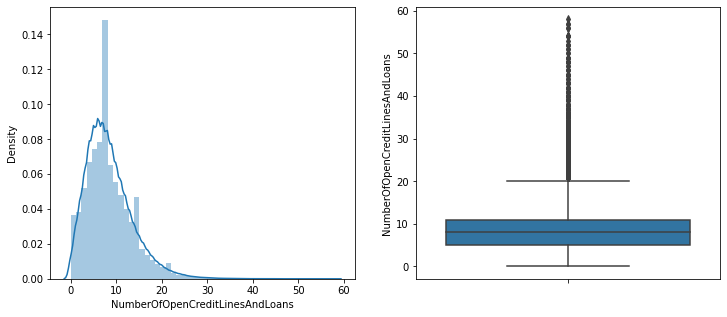

count    150000.000000
mean          8.452760
std           5.145951
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64


In [12]:
f,[ax1,ax2] = plt.subplots(1,2,figsize=(12,5))
sns.distplot(train_data['NumberOfOpenCreditLinesAndLoans'],ax=ax1)
sns.boxplot(y='NumberOfOpenCreditLinesAndLoans',data=train_data,ax=ax2)
plt.show()
print(train_data['NumberOfOpenCreditLinesAndLoans'].describe())
# 由于箱型图的上界值挺连续，所以可能不是异常值

### 2.7固定资产贷款数量

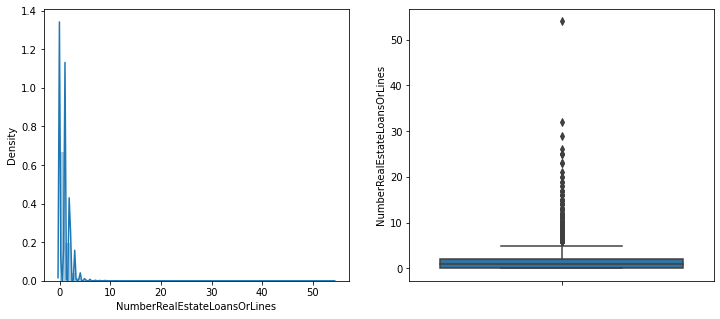

count    150000.000000
mean          1.018240
std           1.129771
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          54.000000
Name: NumberRealEstateLoansOrLines, dtype: float64
----------------------
1


In [13]:
f,[ax1,ax2] = plt.subplots(1,2,figsize=(12,5))
sns.distplot(train_data['NumberRealEstateLoansOrLines'],ax=ax1)
sns.boxplot(y='NumberRealEstateLoansOrLines',data=train_data,ax=ax2)
plt.show()
print(train_data['NumberRealEstateLoansOrLines'].describe())
# 查看箱型图发现最上方有异常值
print('----------------------')
print(train_data[train_data['NumberRealEstateLoansOrLines']>32].shape[0])
# 固定资产贷款数量大于28的有两个，大于32有一个为54，所以决定把>32的当做异常值剔除

### 2.8家属数量分布

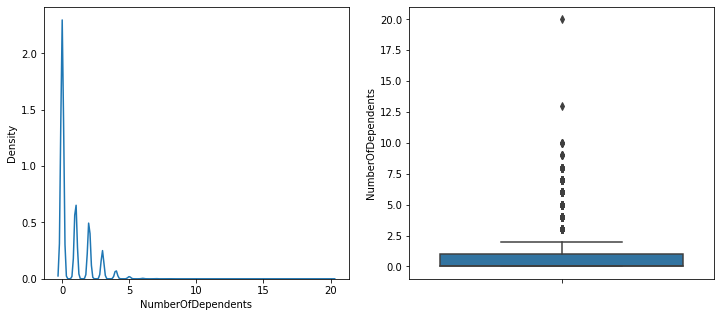

count    146076.000000
mean          0.757222
std           1.115086
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: NumberOfDependents, dtype: float64
----------------------
1
家属数量缺失比例为2.62%


In [14]:
f,[ax1,ax2] = plt.subplots(1,2,figsize=(12,5))
sns.kdeplot(train_data['NumberOfDependents'], ax=ax1)
# sns.distplot(train_data['NumberOfDependents'], ax=ax1)
sns.boxplot(y='NumberOfDependents',data=train_data, ax=ax2)
plt.show()
print(train_data['NumberOfDependents'].describe())
print('----------------------')
print(train_data[train_data['NumberOfDependents']>15].shape[0])
# 由箱型图和描述性统计可以看出，20为异常值，可删除

# 查看缺失比例
x=(train_data['SeriousDlqin2yrs'].count()-train_data['NumberOfDependents'].count())/train_data['SeriousDlqin2yrs'].count()
print('家属数量缺失比例为%.2f%%' % (x*100))
#缺失比例为2.6%，可直接删除

### 2.9月收入分布

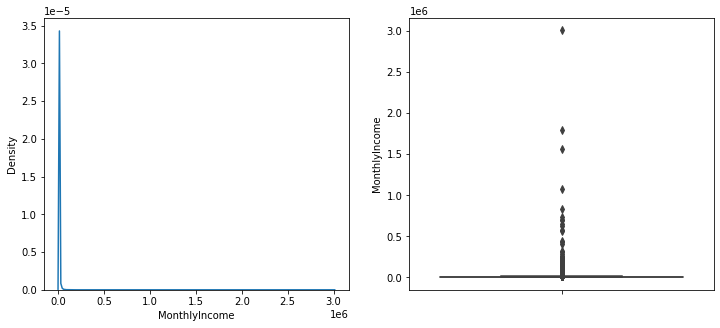

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64
----------------------
1
月收入缺失数量比例为19.81%


In [15]:
f,[ax1,ax2] = plt.subplots(1,2,figsize=(12,5))
sns.kdeplot(train_data['MonthlyIncome'],ax=ax1)
sns.boxplot(y='MonthlyIncome',data=train_data,ax=ax2)
plt.show()
print(train_data['MonthlyIncome'].describe())
print('----------------------')
print(train_data[train_data['MonthlyIncome']>2000000].shape[0])

# 查看缺失比例
x=(test_data['age'].count()-test_data['MonthlyIncome'].count())/test_data['age'].count()
print('月收入缺失数量比例为%.2f%%'%(x*100))
# 由于月收入缺失数量过大，后面采用随机森林的方法填充缺失值

# 3.数据预处理

## 3.1 异常值处理

In [16]:
def strange_delete(data):
    data=data[data['RevolvingUtilizationOfUnsecuredLines']<1]
    data=data[data['age']>18]
    data=data[data['NumberOfTime30-59DaysPastDueNotWorse']<80]
    data=data[data['NumberOfTime60-89DaysPastDueNotWorse']<80]
    data=data[data['NumberOfTimes90DaysLate']<80]
    data=data[data['NumberRealEstateLoansOrLines']<50]
    return data
    
train_data=strange_delete(train_data)
test_data=strange_delete(test_data)

#查看经过异常值处理后是否还存在异常值
train_data.loc[(train_data['RevolvingUtilizationOfUnsecuredLines']>1)|(train_data['age']<18)|(train_data['NumberOfTime30-59DaysPastDueNotWorse']>80)|(train_data['NumberOfTime60-89DaysPastDueNotWorse']>80)|(train_data['NumberOfTimes90DaysLate']>80)|(train_data['NumberRealEstateLoansOrLines']>50)]
test_data.loc[(test_data['RevolvingUtilizationOfUnsecuredLines']>1)|(test_data['age']<18)|(test_data['NumberOfTime30-59DaysPastDueNotWorse']>80)|(test_data['NumberOfTime60-89DaysPastDueNotWorse']>80)|(test_data['NumberOfTimes90DaysLate']>80)|(test_data['NumberRealEstateLoansOrLines']>50)]
print(train_data.shape)
print('----------------------')
print(test_data.shape)

(146391, 11)
----------------------
(99096, 11)


## 3.2缺失值处理

In [17]:
# 对家属数量的缺失值进行删除
train_data=train_data[train_data['NumberOfDependents'].notnull()]
print(train_data.shape)
print('----------------------')
test_data=test_data[test_data['NumberOfDependents'].notnull()]
print(test_data.shape)

(142559, 11)
----------------------
(96535, 11)


In [18]:
# 对月收入缺失值用随机森林的方法进行填充--训练集
# 创建随机森林函数
def fillmonthlyincome(data):
    known = data[data['MonthlyIncome'].notnull()]
    unknown = data[data['MonthlyIncome'].isnull()]
    # 获取除0和5的特征值
    x_train = known.iloc[:, [1,2,3,4,6,7,8,9,10]]
    y_train = known.iloc[:, 5]
    x_test = unknown.iloc[:, [1,2,3,4,6,7,8,9,10]]
    rfr = RandomForestRegressor(random_state=0,n_estimators=200,max_depth=3,n_jobs=-1)
    pred_y = rfr.fit(x_train,y_train).predict(x_test)
    return pred_y
#用随机森林填充训练集缺失值
predict_data=fillmonthlyincome(train_data)
train_data.loc[train_data['MonthlyIncome'].isnull(),'MonthlyIncome']=predict_data

In [19]:
# 对月收入缺失值用随机森林的方法进行填充--测试集
# 创建随机森林函数
def fillmonthlyincome(data):
    known = data[data['MonthlyIncome'].notnull()]
    unknown = data[data['MonthlyIncome'].isnull()]
    x_train = known.iloc[:,[2,3,4,6,7,8,9,10]]
    y_train = known.iloc[:,5]
    x_test = unknown.iloc[:,[2,3,4,6,7,8,9,10]]
    rfr = RandomForestRegressor(random_state=0,n_estimators=200,max_depth=3,n_jobs=-1)
    pred_y = rfr.fit(x_train,y_train).predict(x_test)
    return pred_y
# 用随机森林填充测试集缺失值
predict_data=fillmonthlyincome(test_data)
test_data.loc[test_data['MonthlyIncome'].isnull(),'MonthlyIncome']=predict_data
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96535 entries, 1 to 101503
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      0 non-null      float64
 1   RevolvingUtilizationOfUnsecuredLines  96535 non-null  float64
 2   age                                   96535 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  96535 non-null  int64  
 4   DebtRatio                             96535 non-null  float64
 5   MonthlyIncome                         96535 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       96535 non-null  int64  
 7   NumberOfTimes90DaysLate               96535 non-null  int64  
 8   NumberRealEstateLoansOrLines          96535 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  96535 non-null  int64  
 10  NumberOfDependents                    96535 non-null  float64
dtypes: float64(5),

In [20]:
# 缺失值和异常值处理完后进行检查
print(train_data.isnull().sum())
print('----------------------')
print(test_data.isnull().sum())

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64
----------------------
SeriousDlqin2yrs                        96535
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                               0
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                        

## 3.3 特征工程——特征共线性

In [21]:
# 1、特征间共线性：两个或多个特征包含了相似的信息，期间存在强烈的相关关系 
# 2、常用判断标准：两个或两个以上的特征间的相关性系数高于0.8 
# 3、共线性的影响： 
# 1）降低运算效率 
# 2）降低一些模型的稳定性 
# 3）弱化一些模型的预测能力
# 4、查看共线性的方式：建立共线性表格或热力图
# 5、处理方式：删除或变换

<AxesSubplot:>

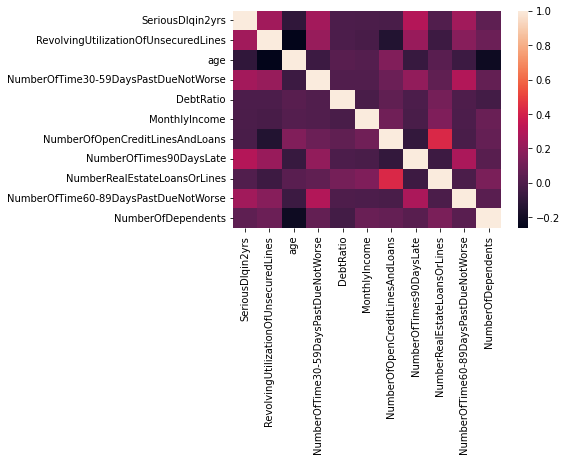

In [22]:
# 可以看到各个变量间的相关性都不大，所以无需剔除变量
correlation_table = train_data.corr()
sns.heatmap(correlation_table)

# 4.特征选择

In [23]:
# 变量分为连续变量和分类变量。
# 在评分卡建模中，变量分箱（binning）是对连续变量离散化（discretization）的一种称呼。
# 要将logistic模型转换为标准评分卡的形式，这一环节是必须完成的。信用评分卡开发中一般有常用的等距分段、等深分段、最优分段。

# 单因子分析，用来检测各变量的预测强度，方法为WOE、IV
# 这里使用IV值进行特征选择并且使用WOE对数据进行分箱。
# WOE的全称是“Weight of Evidence”，即证据权重，WOE是对原始自变量的一种编码形式
# IV的全称是Information Value，中文意思是信息价值，或者信息量；用来衡量自变量的预测能力；类似的指标还有信息增益、基尼系数等等。

## 4.1 分箱

In [24]:
# 连续性变量--- 定义自动分箱函数---最优分箱
# Y: target 变量
# X: 待分箱变量
# bin: 分箱数量
def mono_bin(Y, X, bin_cnt=10):
    r = 0                                # 设定斯皮尔曼 初始值
    bad_num = Y.sum()                    # 计算坏样本数
    good_num = Y.count() - bad_num       # 计算好样本数
    # 下面这段就是分箱的核心 ，就是机器来选择指定最优的分箱节点，代替我们自己来设置
    while np.abs(r) < 1:
        # 用pd.qcut实现最优分箱，Bucket：将X分为n段，n由斯皮尔曼系数决定  
        cut_df = pd.DataFrame({'X': X, 'Y': Y, 'Bucket': pd.qcut(X, bin_cnt)})
        # 按照分箱结果进行分组聚合
        g_df = cut_df.groupby('Bucket', as_index=True)
        # 以斯皮尔曼系数作为分箱终止条件
        r, p = stats.spearmanr(g_df.mean().X, g_df.mean().Y)
        bin_cnt = bin_cnt - 1
        print("r=", r, ", p=", p)
        
    # 构造统计数据df
    df = pd.DataFrame(g_df.X.min(), columns=['min']) # 箱体的左边界
    df['min'] = g_df.min().X
    df['max'] = g_df.X.max()                         # 箱体的右边界
    df['bad'] = g_df.sum().Y                         # 每个箱体中坏样本的数量
    df['total'] = g_df.count().Y                     # 每个箱体的总样本数
    df['rate'] = g_df.mean().Y                       # 每个箱体中坏样本的平均值
    df['woe'] = np.log((df['bad']/bad_num) / ((df['total'] - df['bad'])/good_num))   # 计算每个箱体的woe值
    df['bad_attr'] = df['bad']/bad_num                                               # 每个箱体中坏样本所占坏样本总数的比例
    df['good_attr'] = (df['total'] - df['bad'])/good_num                             # 每个箱体中好样本所占好样本总数的比例
    iv = ((df['bad_attr'] - df['good_attr']) * df['woe']).sum()                      # 计算变量的iv值
    print(df)
    print("==========================================================")
    desc_df = (df.sort_values(by='min', ascending=False)).reset_index(drop=True)                        # 对箱体从大到小进行排序
    print(desc_df)
    print("iv: ", iv)
    woe_list = list(desc_df['woe'].round(3))
    cut_list = [float('-inf')]                        # cut 存放箱段节点, 在列表前加-inf
    for i in range(1, bin_cnt+1):
        qua = X.quantile(i/(bin_cnt+1))               # quantile 分为数  得到分箱的节点
        cut_list.append(round(qua, 4))
    cut_list.append(float('inf'))
    
    return desc_df, iv, cut_list, woe_list
        
    
# 离散型变量-手动分箱
def scatter_bin(Y, X, bin_cnt=10):
    bad_num = Y.sum()                                 # 坏用户数量
    good_num = Y.count() - bad_num                    # 好用户数量
    cut_df = pd.DataFrame({'X': X, 'Y': Y, 'Bucket': pd.cut(X, bin_cnt)})
    g_df = cut_df.groupby('Bucket', as_index=True)
    
    # 构造统计数据df
    df = pd.DataFrame(g_df.X.min(), columns=['min'])
    df['min'] = g_df.min().X
    df['max'] = g_df.max().X
    df['bad'] = g_df.sum().Y
    df['total'] = g_df.count().Y
    df['rate'] = g_df.mean().Y
    df['woe'] = np.log((df['bad']/bad_num)/((df['total'] - df['bad'])/good_num))
    df['bad_attr'] = df['bad']/bad_num                                               # 每个箱体中坏样本所占坏样本总数的比例
    df['good_attr'] = (df['total'] - df['bad'])/good_num                             # 每个箱体中好样本所占好样本总数的比例
    iv = ((df['bad_attr'] - df['good_attr']) * df['woe']).sum()                      # 计算变量的iv值
    
    desc_df = (df.sort_values(by='min', ascending=False)).reset_index(drop=True)                        # 对箱体从大到小进行排序
    print(desc_df)
    print("iv: ", iv)
    woe_list = list(desc_df['woe'].round(3))
    
    return desc_df, iv, woe_list
    
    


In [25]:
x1_d,x1_iv,cutx1_list,woex1_list = mono_bin(train_data['SeriousDlqin2yrs'],train_data.RevolvingUtilizationOfUnsecuredLines)
x2_d,x2_iv,cutx2_list,woex2_list = mono_bin(train_data['SeriousDlqin2yrs'],train_data.age) 
x4_d,x4_iv,cutx4_list,woex4_list = mono_bin(train_data['SeriousDlqin2yrs'],train_data.DebtRatio) 
x5_d,x5_iv,cutx5_list,woex5_list = mono_bin(train_data['SeriousDlqin2yrs'],train_data.MonthlyIncome)

r= 0.8787878787878788 , p= 0.0008138621117322101
r= 0.9 , p= 0.0009430623223403293
r= 0.9285714285714287 , p= 0.0008629681828999769
r= 0.8928571428571429 , p= 0.006807187408935392
r= 0.942857142857143 , p= 0.004804664723032055
r= 0.8999999999999998 , p= 0.03738607346849875
r= 1.0 , p= 0.0
                       min       max   bad  total      rate       woe  \
Bucket                                                                  
(-0.001, 0.0295]  0.000000  0.029534   665  35640  0.018659 -1.203637   
(0.0295, 0.148]   0.029534  0.148034   711  35640  0.019949 -1.135436   
(0.148, 0.521]    0.148035  0.521146  1680  35639  0.047139 -0.247395   
(0.521, 1.0]      0.521148  1.000000  5438  35640  0.152581  1.044468   

                  bad_attr  good_attr  
Bucket                                 
(-0.001, 0.0295]  0.078291   0.260881  
(0.0295, 0.148]   0.083706   0.260538  
(0.148, 0.521]    0.197787   0.253303  
(0.521, 1.0]      0.640217   0.225279  
        min       max   bad  to

In [26]:
ninf = float('-inf')#负无穷大
pinf = float('inf')#正无穷大
cutx3_list = [ninf, 0, 1, 3, 5, pinf]
cutx6_list = [ninf, 1, 2, 3, 5, pinf]
cutx7_list = [ninf, 0, 1, 3, 5, pinf]
cutx8_list = [ninf, 0,1,2, 3, pinf]
cutx9_list = [ninf, 0, 1, 3, pinf]
cutx10_list = [ninf, 0, 1, 2, 3, 5, pinf]
x3_df, ivx3, woex3_list = scatter_bin(train_data.SeriousDlqin2yrs,train_data['NumberOfTime30-59DaysPastDueNotWorse'], cutx3_list)
x6_df, ivx6, woex6_list= scatter_bin(train_data.SeriousDlqin2yrs, train_data['NumberOfOpenCreditLinesAndLoans'], cutx6_list)
x7_df, ivx7, woex7_list = scatter_bin(train_data.SeriousDlqin2yrs, train_data['NumberOfTimes90DaysLate'], cutx7_list)
x8_df, ivx8, woex8_list = scatter_bin(train_data.SeriousDlqin2yrs, train_data['NumberRealEstateLoansOrLines'], cutx8_list)
x9_df, ivx9, woex9_list = scatter_bin(train_data.SeriousDlqin2yrs, train_data['NumberOfTime60-89DaysPastDueNotWorse'], cutx9_list)
x1_df, ivx10, woex10_list = scatter_bin(train_data.SeriousDlqin2yrs, train_data['NumberOfDependents'], cutx10_list)

   min  max   bad   total      rate       woe  bad_attr  good_attr
0    6   13    91     195  0.466667  2.625433  0.010713   0.000776
1    4    5   367     913  0.401972  2.361708  0.043207   0.004073
2    2    3  1449    5620  0.257829  1.701683  0.170591   0.031112
3    1    1  2010   14913  0.134782  0.899640  0.236638   0.096244
4    0    0  4577  120918  0.037852 -0.476517  0.538851   0.867795
iv:  0.6389149816700715
   min  max   bad   total      rate       woe  bad_attr  good_attr
0    6   57  5377  100070  0.053732 -0.109545  0.633035   0.706322
1    4    5  1242   22890  0.054260 -0.099225  0.146221   0.161474
2    3    3   553    8229  0.067201  0.128469  0.065105   0.057256
3    2    2   493    5947  0.082899  0.355369  0.058041   0.040682
4    0    1   829    5423  0.152867  1.046678  0.097598   0.034267
iv:  0.08300647514472649
   min  max   bad   total      rate       woe  bad_attr  good_attr
0    6   17    86     136  0.632353  3.301289  0.010125   0.000373
1    4    5  

## 4.2.1特征选择---相关系数矩阵

In [ ]:
# 三大相关系数:
## 皮尔森相关系数
### 两个变量之间是线性关系，且都是连续数据
### 两个变量的总体是正太分布，或者接近正太的单峰分布
### 两个变量的观测值是成对的，且每对观测值之间是相互独立的

## 斯皮尔曼等级相关系数
### 可使用非正太的数据: 将数值的排序转化为等级的排序

## 肯德尔等级相关系数
### 

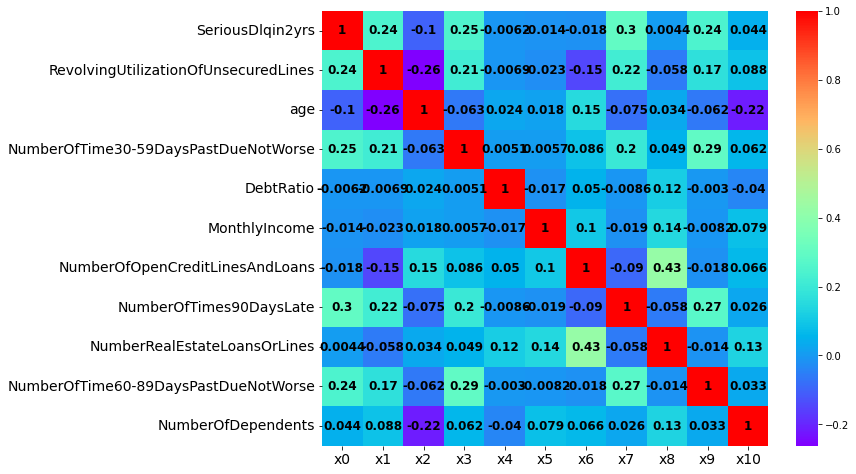

In [27]:
corr = train_data.corr()#计算各变量的相关性系数
xticks = ['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']#x轴标签
yticks = list(corr.index)#y轴标签
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(1, 1, 1)
sns.heatmap(corr, annot=True, cmap='rainbow', ax=ax1, annot_kws={'size': 12, 'weight': 'bold', 'color': 'black'})#绘制相关性系数热力图
ax1.set_xticklabels(xticks, rotation=0, fontsize=14)
ax1.set_yticklabels(yticks, rotation=0, fontsize=14)
plt.show()

# RevolvingUtilizationOfUnsecuredLines、
# NumberOfTime30-59DaysPastDueNotWorse、
# NumberOfTimes90DaysLate
# NumberOfTime60-89DaysPastDueNotWorse
# 四个特征对于我们所要预测的值SeriousDlqin2yrs(因变量)有较强的相关性

## 4.2.2 IV值筛选

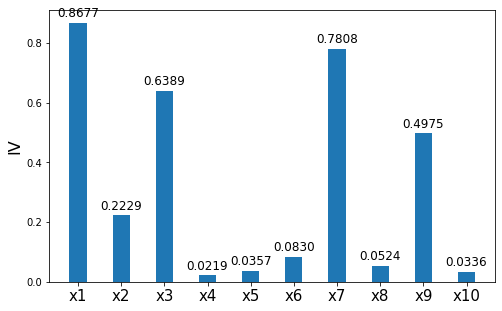

In [28]:
# 通过IV值判断变量预测能力的标准是:
# 小于 0.02: unpredictive
# 0.02 to 0.1: weak
# 0.1 to 0.3: medium
# 0.3 to 0.5: strong
iv_list = [x1_iv,x2_iv,ivx3,x4_iv,x5_iv,ivx6,ivx7,ivx8,ivx9,ivx10]         #各变量IV
index_list = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']              #x轴的标签
fig1 = plt.figure(1,figsize=(8,5))
ax1 = fig1.add_subplot(1, 1, 1)
x = np.arange(len(index_list))+1 
ax1.bar(x, iv_list, width=.4) #  ax1.bar(range(len(index)),ivlist, width=0.4)#生成柱状图  #ax1.bar(x,ivlist,width=.04)
ax1.set_xticks(x)
ax1.set_xticklabels(index_list, rotation=0, fontsize=15)
ax1.set_ylabel('IV', fontsize=16)   #IV(Information Value),
#在柱状图上添加数字标签
for a, b in zip(x, iv_list):
    plt.text(a, b + 0.01, '%.4f' % b, ha='center', va='bottom', fontsize=12)
plt.show()


# 可以看出，DebtRatio (x4)、MonthlyIncome(x5)、NumberOfOpenCreditLinesAndLoans(x6)、
# NumberRealEstateLoansOrLines(x8)和NumberOfDependents(x10)变量的IV值明显较低，所以予以删除。

# 故选择特征：RevolvingUtilizationOfUnsecuredLines（x1）、age（x2）、
# NumberOfTime30-59DaysPastDueNotWorse（x3）、NumberOfTimes90DaysLate（x7）、
# NumberOfTime60-89DaysPastDueNotWorse（x9）作为后续评分模型建立的对象。

# 5.建立模型

In [29]:
train_data.head(1)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
Unnamed: 0,,,,,,,,,,,
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0


In [30]:
# 在建立模型之前，我们需要将筛选后的变量转换为WoE值，便于信用评分

#替换成woe函数
def trans_woe(df,var_name,woe_list,cut_list):
    woe_name=var_name+'_woe'
    for i in range(len(woe_list)):       # len(woe) 得到woe里 有多少个数值
        if i==0:
            df.loc[(df[var_name]<=cut_list[i+1]), woe_name] = woe_list[i]  #将woe的值按 cut_list分箱的下节点，顺序赋值给var的woe_name 列 ，分箱的第一段
        elif (i>0) and  (i<=len(woe_list)-2):
            df.loc[((df[var_name]>cut_list[i])&(df[var_name]<=cut_list[i+1])),woe_name] = woe_list[i] #    中间的分箱区间
        else:
            df.loc[(df[var_name]>cut_list[len(woe_list)-1]),woe_name]=woe_list[len(woe_list)-1]   # 大于最后一个分箱区间的 上限值，最后一个值是正无穷
    return df
x1_name='RevolvingUtilizationOfUnsecuredLines'
x2_name='age'
x3_name='NumberOfTime30-59DaysPastDueNotWorse'
x7_name='NumberOfTimes90DaysLate'
x9_name='NumberOfTime60-89DaysPastDueNotWorse'

In [31]:
train_data=trans_woe(train_data,x1_name,woex1_list,cutx1_list)
train_data=trans_woe(train_data,x2_name,woex2_list,cutx2_list)
train_data=trans_woe(train_data,x3_name,woex3_list,cutx3_list)
train_data=trans_woe(train_data,x7_name,woex7_list,cutx7_list)
train_data=trans_woe(train_data,x9_name,woex9_list,cutx9_list)

Y=train_data['SeriousDlqin2yrs']   #因变量
#自变量，剔除对因变量影响不明显的变量
X=train_data.drop(['SeriousDlqin2yrs','DebtRatio','MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines','NumberOfDependents'],axis=1)
X=train_data.iloc[:,-5:]
X.head()

,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30-59DaysPastDueNotWorse_woe,NumberOfTimes90DaysLate_woe,NumberOfTime60-89DaysPastDueNotWorse_woe
Unnamed: 0,,,,,
1,-1.204,-0.482,1.702,3.301,2.982
2,-1.204,-0.869,2.625,3.301,2.982
3,-1.204,-0.869,2.362,3.278,2.982
4,-1.135,-1.036,2.625,3.301,2.982
5,-1.204,-0.186,2.362,3.301,2.982


In [32]:
woex1_list

[1.044, -0.247, -1.135, -1.204]

In [33]:
# STATSMODEL包来建立逻辑回归模型得到回归系数，后面可用于建立标准评分卡
import statsmodels.api as sm
X1=sm.add_constant(X)
logit=sm.Logit(Y,X1)
model=logit.fit()
print(model)
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.189904
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               142559
Model:                          Logit   Df Residuals:                   142553
Method:                           MLE   Df Model:                            5
Date:                Mon, 18 Jul 2022   Pseudo R-squ.:                  0.1590
Time:                        16:18:41   Log-Likelihood:                -27073.
converged:                       True   LL-Null:                       -32192.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       10.3

In [34]:
# Logistic回归模型——将训练集的数据分为测试集和训练集
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

clf = LogisticRegression()
clf.fit(X,Y)
#对测试集做预测
# score_proba = clf.predict_proba(x_test)
# y_predproba=score_proba[:,1]
coe = clf.coef_
print("coe: ", coe)
print("intercept: ", clf.intercept_)


coe:  [[-0.79485377 -0.50456853 -1.3250292  -1.94510528 -1.39299188]]
intercept:  [10.29886656]


# 6.模型评估

In [35]:
#评估
from sklearn import metrics

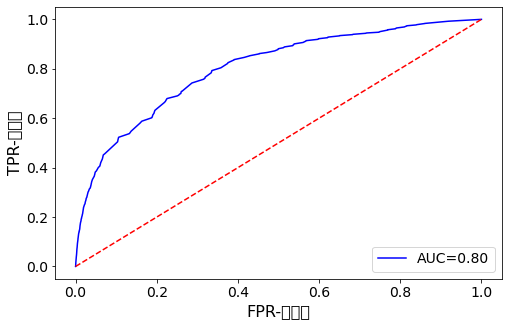

In [36]:
## AUC
train_data_test = sm.add_constant(X)
predict_y = model.predict(train_data_test)               # 进行预测
fpr, tpr, threshold = metrics.roc_curve(Y, predict_y)    # 评估算法
rocauc = metrics.auc(fpr, tpr)                           # 计算AUC
plt.figure(figsize=(8,5))  #只能在这里面设置
plt.plot(fpr,tpr,'b',label='AUC=%0.2f'% rocauc)
plt.legend(loc='lower right',fontsize=14)
plt.plot([0.0, 1.0], [0.0, 1.0], 'r--')
plt.xlim=([0.0, 1.0])
plt.ylim=([0.0, 1.0])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('TPR-真正率',fontsize=16)
plt.xlabel('FPR-假正率',fontsize=16)
plt.show()

In [37]:
# # KS 指标
# https://zhuanlan.zhihu.com/p/79934510 【风控模型—区分度评估指标(KS)深入理解应用】
# KS指标: 用以评估模型对好、坏客户的判别区分能力，计算累计坏客户与累计好客户百分比的最大差距。KS值范围在0%-100%，判别标准如下：
# KS: <20% : 差
# KS: 20%-40% : 一般
# KS: 41%-50% : 好
# KS: 51%-75% : 非常好
# KS: >75% : 过高，需要谨慎的验证模型

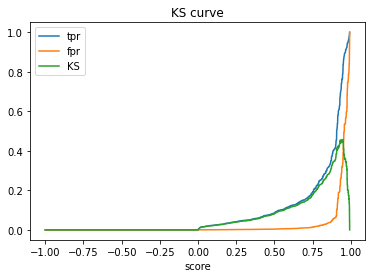

<Figure size 1440x1440 with 0 Axes>

max(tpr-fpr):  0.45692213969953377


In [38]:
fig, ax = plt.subplots()
ax.plot(1-threshold, tpr,label='tpr')
ax.plot(1-threshold, fpr,label='fpr')
ax.plot(1-threshold, tpr-fpr,label='KS')
plt.xlabel('score')
plt.title('KS curve')
plt.xlim=([0.0,1.0])
plt.ylim=([0.0,1.0])
plt.figure(figsize=(20,20))
legend=ax.legend(loc='upper left')
plt.show()
print("max(tpr-fpr): ", max(tpr-fpr))

# 7.创建信用评分卡

In [39]:
# 在建立标准评分卡之前，还需要设定几个评分卡参数: 基础分值、 PDO（比率翻倍的分值）和好坏比。 
# 这里， 我们取600分为基础分值b，取20为PDO （每高20分好坏比翻一倍）

In [40]:
p = 20/np.log(2)                                             # 比例因子
q = 600-20*np.log(20)/np.log(2)                              # 等于offset,偏移量
x_coe_list = [-2.7340, 0.6526, 0.5201, 0.5581, 0.5943, 0.4329]    # 回归系数
baseScore = round(q + p*x_coe_list[0], 0)

#个人总评分=基础分+各部分得分
def get_score(coe, woe_list, factor):
    scores = []
    for w in woe_list:
        score=round(coe*w*factor,0)
        scores.append(score)
    return scores

#每一个特征项得分
x1_score_list = get_score(x_coe_list[1], woex1_list, p)
x2_score_list = get_score(x_coe_list[2], woex2_list, p)
x3_score_list = get_score(x_coe_list[3], woex3_list, p)
x7_score_list = get_score(x_coe_list[4], woex7_list, p)
x9_score_list = get_score(x_coe_list[5], woex9_list, p)

def compute_score(series, cut_list, score_list):
    res_list = []
    i = 0
    while i < len(series):
        #print(series[i].dtype)
        #print(series.iloc[i])
        value = series.iloc[i]
        j = len(cut_list) - 2
        m = len(cut_list) - 2
        while j >= 0:
            if value >= cut_list[j]:
                j = -1
            else:
                j -= 1
                m -= 1
        res_list.append(score_list[m])
        i += 1
    return res_list

In [41]:
train_data.head(1)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30-59DaysPastDueNotWorse_woe,NumberOfTimes90DaysLate_woe,NumberOfTime60-89DaysPastDueNotWorse_woe
Unnamed: 0,,,,,,,,,,,,,,,,
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,-1.204,-0.482,1.702,3.301,2.982


In [42]:
col_name_list = {'x1': 'RevolvingUtilizationOfUnsecuredLines',
                 'x2': 'age',
                 'x3':'NumberOfTime30-59DaysPastDueNotWorse',
                 'x7':'NumberOfTimes90DaysLate',
                 'x9':'NumberOfTime60-89DaysPastDueNotWorse'}
train_data['BaseScore'] = np.zeros(len(train_data)) + baseScore
train_data['x1'] = compute_score(train_data['RevolvingUtilizationOfUnsecuredLines'], cutx1_list, x1_score_list)
train_data['x2'] = compute_score(train_data['age'], cutx2_list, x2_score_list)
train_data['x3'] = compute_score(train_data['NumberOfTime30-59DaysPastDueNotWorse'], cutx3_list, x3_score_list)
train_data['x7'] = compute_score(train_data['NumberOfTimes90DaysLate'], cutx7_list, x7_score_list)
train_data['x9'] = compute_score(train_data['NumberOfTime60-89DaysPastDueNotWorse'],cutx9_list, x9_score_list)
train_data['Score'] = train_data['x1'] + train_data['x2'] + train_data['x3'] + train_data['x7'] +train_data['x9']  + baseScore

score_df = train_data.iloc[:,[0,-7,-6,-5,-4,-3,-2,-1]]  #选取需要的列，就是评分列
score_df.head()


,SeriousDlqin2yrs,BaseScore,x1,x2,x3,x7,x9,Score
Unnamed: 0,,,,,,,,
1,1,435.0,-23.0,-3.0,27.0,56.0,34.0,526.0
2,0,435.0,-23.0,-7.0,38.0,56.0,34.0,533.0
3,0,435.0,-23.0,-13.0,27.0,47.0,34.0,507.0
4,0,435.0,-21.0,-16.0,38.0,56.0,34.0,526.0
5,0,435.0,-23.0,-3.0,27.0,56.0,34.0,526.0


In [43]:
score_df = score_df.rename(columns=col_name_list, inplace=False)
score_df.head()

# score_df.to_excel('./训练集评分卡.xlsx')

,SeriousDlqin2yrs,BaseScore,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,Score
Unnamed: 0,,,,,,,,
1,1,435.0,-23.0,-3.0,27.0,56.0,34.0,526.0
2,0,435.0,-23.0,-7.0,38.0,56.0,34.0,533.0
3,0,435.0,-23.0,-13.0,27.0,47.0,34.0,507.0
4,0,435.0,-21.0,-16.0,38.0,56.0,34.0,526.0
5,0,435.0,-23.0,-3.0,27.0,56.0,34.0,526.0


# 8. 预测测试集

In [44]:
test_data.head(1)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
Unnamed: 0,,,,,,,,,,,
1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0


In [45]:
#预测测试集
#测试集转化为WOE值
test_data=trans_woe(test_data,x1_name,woex1_list,cutx1_list)
test_data=trans_woe(test_data,x2_name,woex2_list,cutx2_list)
test_data=trans_woe(test_data,x3_name,woex3_list,cutx3_list)
test_data=trans_woe(test_data,x7_name,woex7_list,cutx7_list)
test_data=trans_woe(test_data,x9_name,woex9_list,cutx9_list)
test_data.head(1)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30-59DaysPastDueNotWorse_woe,NumberOfTimes90DaysLate_woe,NumberOfTime60-89DaysPastDueNotWorse_woe
Unnamed: 0,,,,,,,,,,,,,,,,
1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0,-1.204,-0.482,2.625,3.301,2.982


In [46]:
# #自变量，剔除对因变量影响不明显的变量
# test_data=test_data.drop(['DebtRatio','MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines','NumberOfDependents'],axis=1)

In [47]:
test_X_data = test_data.iloc[:,-5:]
test_Y_data = test_data['SeriousDlqin2yrs']   # 因变量
test_X_data.head(1)

,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30-59DaysPastDueNotWorse_woe,NumberOfTimes90DaysLate_woe,NumberOfTime60-89DaysPastDueNotWorse_woe
Unnamed: 0,,,,,
1,-1.204,-0.482,2.625,3.301,2.982


In [48]:

# X_train=training.copy().iloc[:,-5:]
# Y_train=training.copy()['SeriousDlqin2yrs']
# clf = LogisticRegression()
# clf.fit(X_train,Y_train)
#对测试集做预测
sm_test_X_data = sm.add_constant(test_X_data)
score_proba = model.predict(sm_test_X_data)
score_proba

Unnamed: 0
1         0.072131
2         0.049123
3         0.024871
4         0.112514
5         0.093232
            ...   
101498    0.023513
101499    0.088698
101500    0.243125
101502    0.070486
101503    0.088698
Length: 96535, dtype: float64

In [49]:
test_data['y_predproba'] = score_proba
test_data.head(1)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30-59DaysPastDueNotWorse_woe,NumberOfTimes90DaysLate_woe,NumberOfTime60-89DaysPastDueNotWorse_woe,y_predproba
Unnamed: 0,,,,,,,,,,,,,,,,,
1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0,-1.204,-0.482,2.625,3.301,2.982,0.072131


In [50]:
#每一项得分
test_x1_score = get_score(x_coe_list[1], woex1_list, p)
test_x2_score = get_score(x_coe_list[2], woex2_list, p)
test_x3_score = get_score(x_coe_list[3], woex3_list, p)
test_x7_score = get_score(x_coe_list[4], woex7_list, p)
test_x9_score = get_score(x_coe_list[5], woex9_list, p)

In [51]:
test_data['BaseScore'] = np.zeros(len(test_data)) + baseScore
test_data['x1'] =compute_score(test_data['RevolvingUtilizationOfUnsecuredLines'], cutx1_list, test_x1_score)
test_data['x2'] = compute_score(test_data['age'], cutx2_list, test_x2_score)
test_data['x3'] = compute_score(test_data['NumberOfTime30-59DaysPastDueNotWorse'], cutx3_list, test_x3_score)
test_data['x7'] = compute_score(test_data['NumberOfTimes90DaysLate'], cutx7_list, test_x7_score)
test_data['x9'] = compute_score(test_data['NumberOfTime60-89DaysPastDueNotWorse'],cutx9_list, test_x9_score)
test_data['Score'] = test_data['x1'] + test_data['x2'] + test_data['x3'] + test_data['x7'] + test_data['x9']  + baseScore
test_data.head(1)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,...,NumberOfTimes90DaysLate_woe,NumberOfTime60-89DaysPastDueNotWorse_woe,y_predproba,BaseScore,x1,x2,x3,x7,x9,Score
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,...,3.301,2.982,0.072131,435.0,-23.0,-7.0,38.0,56.0,34.0,533.0


In [52]:
test_result_df = test_data.iloc[:,[0,-8,-7,-6,-5,-4,-3,-2,-1]]  #选取需要的列，就是评分列
test_result_df.head(1)

,SeriousDlqin2yrs,y_predproba,BaseScore,x1,x2,x3,x7,x9,Score
Unnamed: 0,,,,,,,,,
1,NaN,0.072131,435.0,-23.0,-7.0,38.0,56.0,34.0,533.0


In [53]:
col_name_dict = {'x1': 'RevolvingUtilizationOfUnsecuredLines',
                 'x2':'age',
                 'x3':'NumberOfTime30-59DaysPastDueNotWorse',
                 'x7':'NumberOfTimes90DaysLate',
                 'x9':'NumberOfTime60-89DaysPastDueNotWorse'}
tset_final_df = test_result_df.rename(columns=col_name_dict, inplace=False)
tset_final_df.head(1)

,SeriousDlqin2yrs,y_predproba,BaseScore,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,Score
Unnamed: 0,,,,,,,,,
1,NaN,0.072131,435.0,-23.0,-7.0,38.0,56.0,34.0,533.0
